# Image Stitching

* Stitch two images using OpenCV by estimating homography

In [32]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import argparse
import sys

plt.rcParams['figure.figsize'] = [16, 9]



## Image Stitching

* Feature detection
* Feature matching & homography estimation using RANSAC
* align two images using estimated homography
* Stitching

How can we remove this seam?

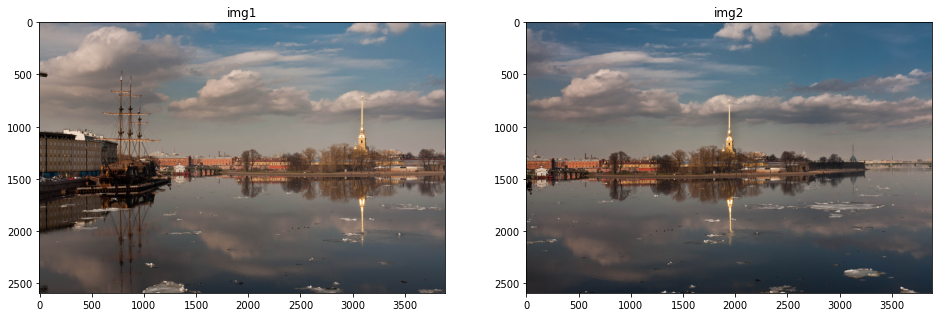

In [33]:
# read images
img_names = ['resources/boat1.jpg','resources/boat2.jpg']
img1 = cv.imread(img_names[0])
img2 = cv.imread(img_names[1])

plt.subplot(1,2,1), plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB)), plt.title('img1')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB)), plt.title('img2')
plt.show()

In [34]:
# Initiate SIFT detector
# TODO
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT (mask=None)
# TODO
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

### Visualize Features

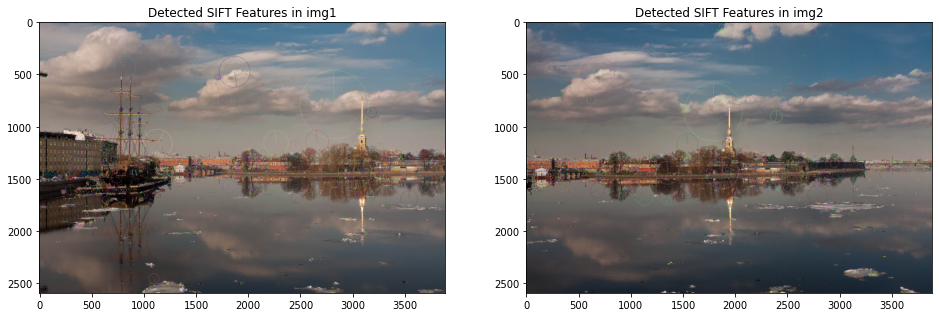

In [35]:
img1_vis = np.zeros_like(img1)
img2_vis = np.zeros_like(img2)

img1_vis = cv.drawKeypoints(img1, kp1, img1_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_vis = cv.drawKeypoints(img2, kp2, img2_vis, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(1,2,1), plt.imshow(cv.cvtColor(img1_vis, cv.COLOR_BGR2RGB)), plt.title('Detected SIFT Features in img1')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(img2_vis, cv.COLOR_BGR2RGB)), plt.title('Detected SIFT Features in img2')
plt.show()


### Feature matching

In [72]:
# Create FLANN based matcher
# TODO
matcher = cv.FlannBasedMatcher()

# compute k best matches (k=2)
# TODO
matches = matcher.knnMatch(des1, des2, k=2) # Brute match대신 knn match

# store all the good matches as per Lowe's ratio test.
# matches.distance - Distance between descriptors. The lower, the better it is.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance: # Lowe's ratio test.
        good.append(m) # 첫번째 distance가 두번째 distance의 0.7보다 작으면 good, good만 사용
print(type(matches))
print(type(good[0]))
print(dir(good[0]))
print(good[0].queryIdx)
# bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
# good = bf.match(des1, des2)

print(len(good))

<class 'list'>
<class 'cv2.DMatch'>
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
86
3496


* Draw matched points:

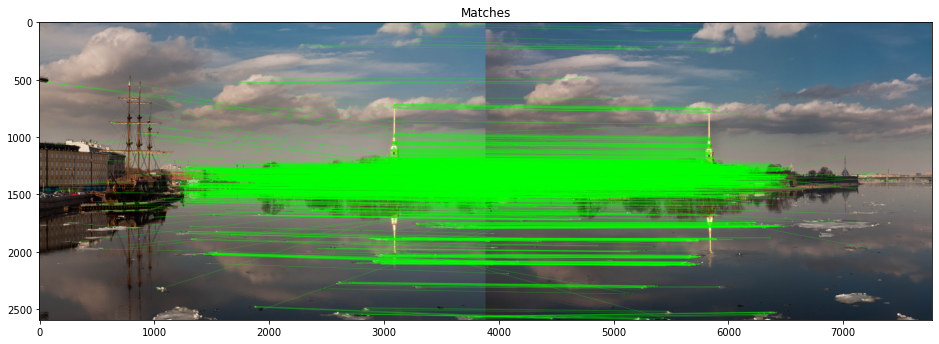

In [59]:
# draw matches
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_matches = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

plt.imshow(cv.cvtColor(img_matches,cv.COLOR_BGR2RGB)), plt.title('Matches')
plt.show()

### Find Homography

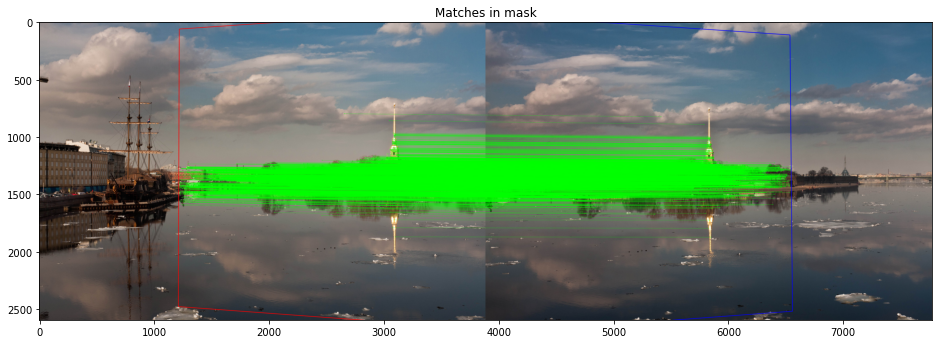

In [38]:
# find homography (method=cv2.RANSAC, ransacReprojThreshold=5.0)
# TODO
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# perspective transform
h, w, c = img1.shape
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst1 = cv.perspectiveTransform(pts, M)

h, w, c = img2.shape
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst2 = cv.perspectiveTransform(pts, np.linalg.inv(M))

img2_poly = cv.polylines(img2.copy(), [np.int32(dst1)], True, (255,0,0), 3, cv.LINE_AA)
img1_poly = cv.polylines(img1.copy(), [np.int32(dst2)], True, (0,0,255), 3, cv.LINE_AA)

# draw matches
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img3 = cv.drawMatches(img1_poly, kp1, img2_poly, kp2, good, None, **draw_params)

plt.imshow(cv.cvtColor(img3,cv.COLOR_BGR2RGB)), plt.title('Matches in mask')
plt.show()

### Image stitching

In [56]:
# define output image space
out_width = img2.shape[1] * 2 
out_height = img2.shape[0] * 2
I = np.eye(3)
A = np.eye(3)
A[0:2,2] = [out_width//4, out_height//4] # width, height 이동 시켜주는 matrix

# define mask
mask1 = np.ones_like(img1)
mask2 = np.ones_like(img2)

# get inv(M)
# TODO
M_inv = np.linalg.inv(M)

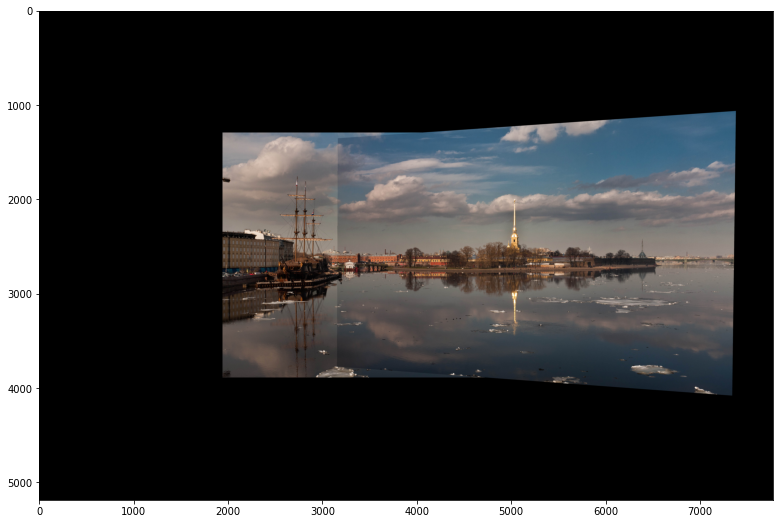

In [57]:
# warp img2 into output space with img1 camera pose (use M=A@M_inv, dsize=(out_width, out_height))
# TODO

img2_out = cv.warpPerspective(img2, A@M_inv, (out_width, out_height))
mask2_out = cv.warpPerspective(mask2, A@M_inv, (out_width, out_height))

# warp img1 into output space (use M=A, dsize=(out_width, out_height))
img1_out = cv.warpPerspective(img1, A@I, (out_width, out_height))
mask1_out = cv.warpPerspective(mask1, A@I, (out_width, out_height))

# stitch images
# alpha blending
img_stitch = img1_out
img_stitch = (1-mask2_out) * img_stitch +  mask2_out * img2_out


# display
img_stitch = np.clip(img_stitch,0,255).astype(np.uint8)
plt.imshow(cv.cvtColor(img_stitch, cv.COLOR_BGR2RGB))
plt.show()

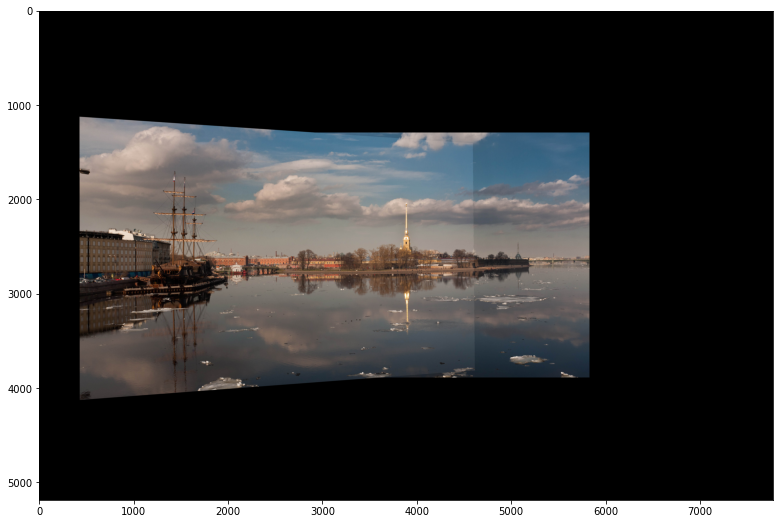

In [41]:
# warp img1 into output space with img2 camera pose (use M=A@M_inv, dsize=(out_width, out_height))
# TODO
img1_out = cv.warpPerspective(img1, A@M, (out_width, out_height))
mask1_out = cv.warpPerspective(mask1, A@M, (out_width, out_height))

# warp img2 into output space (use M=A, dsize=(out_width, out_height))
img2_out = cv.warpPerspective(img2, A@I, (out_width, out_height))
mask2_out = cv.warpPerspective(mask2, A@I, (out_width, out_height))

# stitch images
# alpha blending
img_stitch = img2_out
img_stitch = (1-mask1_out) * img_stitch +  mask1_out * img1_out


# display
img_stitch = np.clip(img_stitch,0,255).astype(np.uint8)
plt.imshow(cv.cvtColor(img_stitch, cv.COLOR_BGR2RGB))
plt.show()